# Migdal Tutorial
Tutorial to compute Migdal rates according to different models.
Models from two sources are currently implemented:
 - **Ibe**: https://link.springer.com/article/10.1007/JHEP03(2018)194
 - **Cox**: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.035032



In [1]:
import matplotlib.pyplot as plt
import numericalunits as nu
import numpy as np
import pandas as pd
import seaborn as sns

import wimprates as wr

sns.set_theme()
sns.set_style('ticks')

/home/loren/projects/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(
/home/loren/projects/wimprates/wimprates/utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


------------------------------------------
Migdal ionisation probabilities
P. Cox, M. Dolan, C. McCabe, H. Quiney (2022)
arXiv:2208.12222
------------------------------------------


### Convert Xe.dat to nicer format (Ibe)

In [2]:
SOURCE='Xe'
df = dict()
with open(wr.data_file(f'migdal/Ibe/{SOURCE}.dat')) as f:
    header = False
    for i, line in enumerate(f.read().splitlines()):
        if 'Principal' in line:
            header = True
            continue
        if 'Energy' in line:
            header = False
            continue
            
        if header:
            n, l = [int(x) for x in line.split()]
        else:
            e, rate = [float(x) for x in line.split()]
            df.setdefault(e, dict())
            df[e]['%d_%d' % (n, l)] = rate
                
df = pd.DataFrame(df).T
df['E'] = df.index

df.to_csv('migdal_transition_ps.csv', index=False)
df_migdal = df
df.head()

,1_0,2_0,2_1,3_0,3_1,3_2,4_0,4_1,4_2,5_0,5_1,E
1.000000,1.013107e-14,2.538509e-13,1.417923e-12,3.745613e-12,1.931796e-11,6.875756e-12,4.272023e-11,2.097481e-10,2.115778e-09,4.937655e-10,5.173118e-07,1.000000
1.045636,1.013389e-14,2.539291e-13,1.424572e-12,3.746781e-12,1.941191e-11,6.950745e-12,4.272690e-11,2.096290e-10,2.124282e-09,4.851036e-10,5.103404e-07,1.045636
1.093354,1.013681e-14,2.540099e-13,1.431461e-12,3.747978e-12,1.950850e-11,7.033516e-12,4.273357e-11,2.095044e-10,2.133447e-09,4.762062e-10,5.031270e-07,1.093354
1.143250,1.013985e-14,2.540935e-13,1.438595e-12,3.749203e-12,1.960773e-11,7.124774e-12,4.274019e-11,2.093738e-10,2.143335e-09,4.670743e-10,4.956689e-07,1.143250
1.195423,1.014299e-14,2.541800e-13,1.445980e-12,3.750456e-12,1.970957e-11,7.225280e-12,4.274673e-11,2.092371e-10,2.154013e-09,4.577099e-10,4.879646e-07,1.195423


Rows are energies, columns are (n, l) states. Data is the differential transition probabilities, at the 1 eV/c reference momentum, not divided by 2 pi.

### Reproduce figure 4

To reproduce figure 4 of https://arxiv.org/pdf/1707.07258.pdf, we must
  * Convert to the other reference momentum of $m_e * .001 c$
  * Divide by 2 pi.
  * Convert eV -> keV; multiply energies by 1e3 and divide differential probabilities by 1e3.

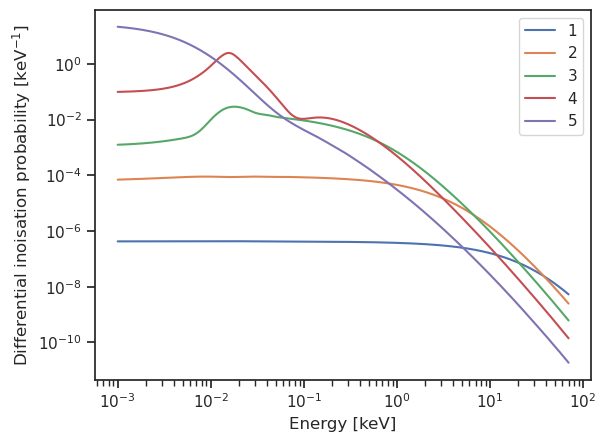

In [3]:
scale = ((nu.me * 1e-3 * nu.c0)/(nu.eV / nu.c0))**2 / (2 * np.pi)
df2, _ = wr.migdal.read_migdal_transitions(SOURCE)
for n in df.keys():
    x = df_migdal[n].values.copy()
    if not n.endswith('0'):
        continue
    for c in df2.keys():
        if c.startswith(str(n).split('_')[0]) and not c.endswith('0'):
            x += df[c]
    
    plt.plot(df['E'] / 1e3, x * scale * 1e3, label=n[0])

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Energy [keV]")
plt.ylabel("Differential inoisation probability [keV$^{-1}$]")
plt.legend()

## Using the iterator getter for different models
The getter function `wr.get_migdal_transitions_probability_iterators` provides a list of instanses of the Shell class.


In [4]:
wr.migdal.Shell?

Init signature:
wr.migdal.Shell(
    name: str,
    element: str,
    binding_e: float,
    model: str,
    single_ionization_probability: collections.abc.Callable,
) -> None
Docstring:     
Describes a specific atomic shell for the selected atom.

Attributes:
    name (str): The name of the shell.
    element (str): The element class of the atom.
    binding_e (float): The binding energy for the shell.
    model (str): The model used for the single ionization probability computation.
    single_ionization_probability (Callable): A function to assign interpolators to.
        The interpolator will provide the single ionization probability for the shell
        according to the selected model.

Methods:
    __call__(*args, **kwargs) -> np.ndarray:
        Calls the single_ionization_probability function with the given arguments and keyword arguments.

Properties:
    n (int): Primary quantum number.
    l (str): Azimuthal quantum number for Ibe; Azimuthal + magnetic quantum number for C

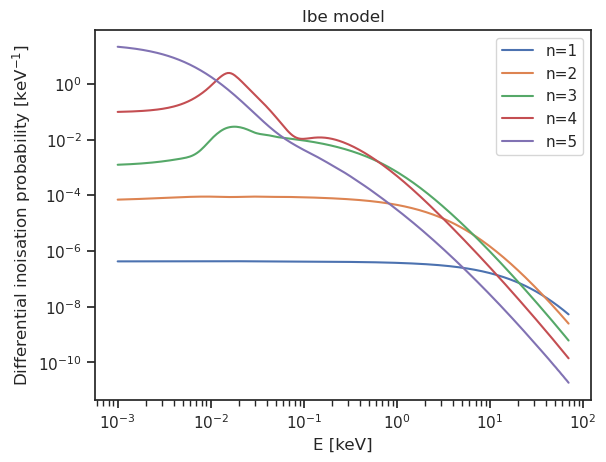

In [5]:
scale = ((nu.me * 1e-3 * nu.c0)/(nu.eV / nu.c0))**2 / (2 * np.pi)
shells_ibe = wr.get_migdal_transitions_probability_iterators(material=SOURCE, model="Ibe", considered_shells=("*"))

E = df["E"].to_numpy() * nu.eV

for shell in shells_ibe:
    x = shell(E)
    if shell.l != "_0":
        continue
    for _shell in shells_ibe:
        if shell.n == _shell.n  and _shell.l != "_0":
            x += _shell(E)
    plt.plot(E / nu.keV, x * scale * nu.keV, label=f"n={shell.n}")
    

plt.xscale('log')
plt.yscale('log')
plt.title("Ibe model")
plt.xlabel("E [keV]")
plt.ylabel("Differential inoisation probability [keV$^{-1}$]")
plt.legend()
plt.show()

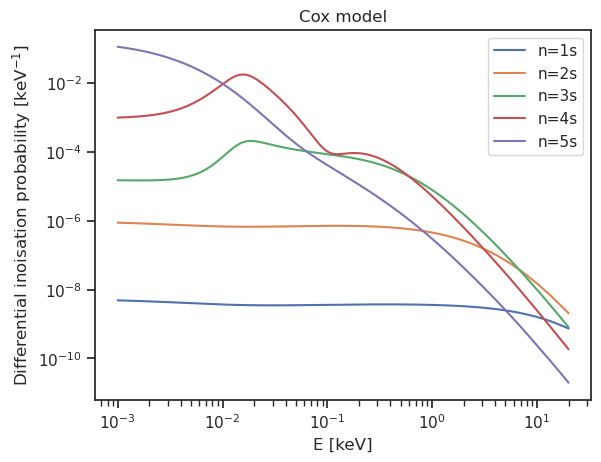

In [6]:
fig, ax = plt.subplots()
shells_cox = wr.get_migdal_transitions_probability_iterators(material=SOURCE, model="Cox", considered_shells=("*",))


E = np.logspace(0, np.log10(20e3), 1000) * nu.eV
v = np.repeat(1e-4, len(E))

def print_f(arr, pref=""):
    if arr is not None:
        return 0
    print(f"{pref} {arr[:2]=}")
for shell in shells_cox:
    x = shell(E.copy(), v=v)
    if shell.l != "s":
        continue
    for _shell in shells_cox:
        if shell.n == _shell.n  and _shell.l != "s":
            x += _shell(E.copy(), v=v)
    ax.plot(E / nu.keV, x * nu.keV, label=f"n={shell.name}")
    


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Cox model")
ax.set_xlabel("E [keV]")
ax.set_ylabel("Differential inoisation probability [keV$^{-1}$]")
ax.legend()
plt.show()

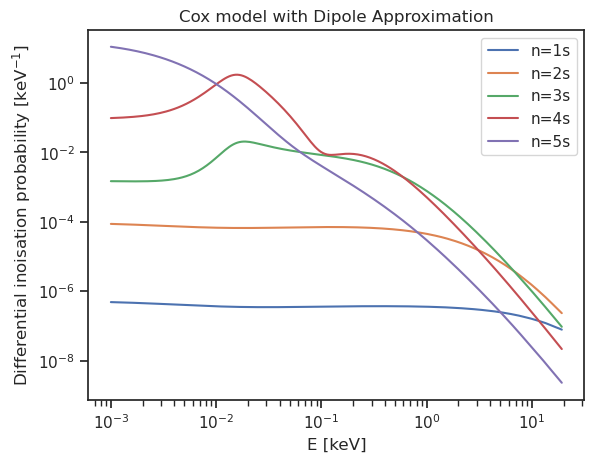

In [7]:
fig, ax = plt.subplots()
shells_cox_dipole = wr.get_migdal_transitions_probability_iterators(material=SOURCE, model="Cox", dipole=True, considered_shells=("*",))


E = df["E"].to_numpy().copy() * nu.eV
v = np.repeat(1e-3, len(E))

def print_f(arr, pref=""):
    if arr is not None:
        return 0
    print(f"{pref} {arr[:2]=}")
for shell in shells_cox_dipole:
    x = shell(E.copy(), v=v)
    if shell.l != "s":
        continue
    for _shell in shells_cox_dipole:
        if shell.n == _shell.n  and _shell.l != "s":
            x += _shell(E.copy(), v=v)
    ax.plot(E / nu.keV, x * nu.keV, label=f"n={shell.name}")
    


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Cox model with Dipole Approximation")
ax.set_xlabel("E [keV]")
ax.set_ylabel("Differential inoisation probability [keV$^{-1}$]")
ax.legend()
plt.show()

### Compare with spectrum from LUX talk

To verify we have the correct spectrum, let's compare to a curve trace from slide 10 of a [recent LUX talk](https://indico.cern.ch/event/699961/contributions/3043408/attachments/1692619/2723656/JLIN_Sub_GeV_DM_Talk_IDM2018_V4.pdf)

In [8]:
es = np.logspace(np.log10(5e-2), np.log10(2), 100) *  nu.keV

WIMP_MASS = 0.5 # GeV
SIGMA = 1e-35 # cm^2

def extract_exponent(num):
    # Convert the number to a string in scientific notation
    num_str = f"{num:.1e}"
    # Split the string on 'e' to separate the mantissa and exponent
    num, exponent_str = num_str.split('e')
    # Convert the exponent part to an integer
    exponent = int(exponent_str)
    return num, exponent

_, SIGMA_Exp = extract_exponent(SIGMA)

In [11]:
rs_ibe = wr.rate_migdal(
        w=es,
        mw=0.5 * nu.GeV/nu.c0**2,
        sigma_nucleon=1e-35 * nu.cm**2,
        migdal_model="Ibe",
        progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

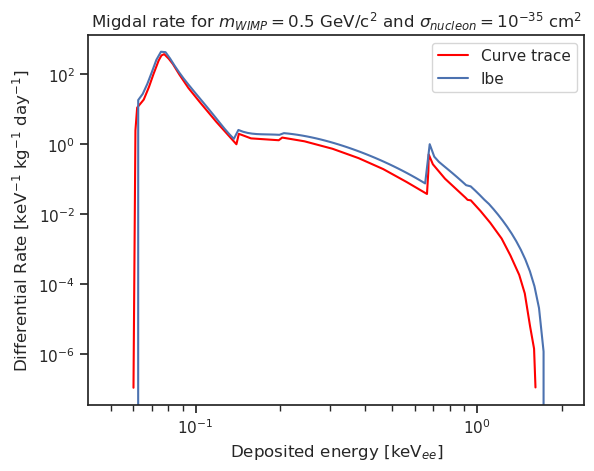

In [12]:
fig, ax = plt.subplots()

ref_curve = pd.read_csv("migdal_0.5gev_curvetrace_lux.csv", index_col=False)
ax.plot(
    10 ** ref_curve["logE"], 10 ** ref_curve["logR"], color="red", label="Curve trace"
)
ax.plot(es / nu.keV, rs_ibe * (nu.kg * nu.day * nu.keV), label="Ibe")

ax.set_title(rf"Migdal rate for $m_{{WIMP}} = {WIMP_MASS}$ GeV/c$^2$ and $\sigma_{{nucleon}} = 10^{{{SIGMA_Exp}}}$ cm$^2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Deposited energy [keV$_{ee}$]")
ax.set_ylabel("Differential Rate [keV$^{-1}$ kg$^{-1}$ day$^{-1}$]")
plt.legend()

Looks good! The remaining deviations look like curve tracing artifacts.

## Comparing Cox and Ibe models

In [13]:
WITH_DIPOLE = False

rs_cox = wr.rate_migdal(
    w=es,
    mw=WIMP_MASS * nu.GeV / nu.c0**2,
    sigma_nucleon=SIGMA * nu.cm**2,
    migdal_model="Cox",
    dipole=False,
    # e_threshold=0.1 * nu.keV,
    progress_bar=True,
)
if WITH_DIPOLE:
    rs_cox_dipole = wr.rate_migdal(
        w=es,
        mw=WIMP_MASS * nu.GeV / nu.c0**2,
        sigma_nucleon=SIGMA * nu.cm**2,
        migdal_model="Cox",
        dipole=True,
        include_approx_nr=False,
        progress_bar=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
df_rs = pd.DataFrame(dict(
    E=es/nu.keV,
    r_cox=rs_cox * (nu.kg * nu.day * nu.keV),
    r_ibe=rs_ibe* (nu.kg * nu.day * nu.keV),
))
if WITH_DIPOLE:
    df_rs['r_cox_dipole'] = rs_cox_dipole * (nu.kg * nu.day * nu.keV)

df_rs = df_rs.melt(id_vars='E')

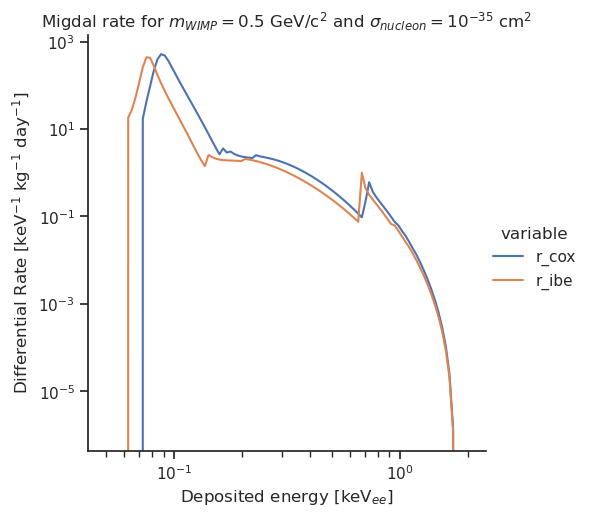

In [15]:
import seaborn as sns

g = sns.relplot(data=df_rs, x="E", y="value", hue="variable", kind="line")
g.set(
    xscale="log",
    yscale="log",
    xlabel=r"Deposited energy [keV$_{ee}$]",
    ylabel="Differential Rate [keV$^{-1}$ kg$^{-1}$ day$^{-1}$]",
    title=rf"Migdal rate for $m_{{WIMP}} = {WIMP_MASS}$ GeV/c$^2$ and $\sigma_{{nucleon}} = 10^{{{SIGMA_Exp}}}$ cm$^2$",
)

The observed discrepancies between the models are due to multiple factors:
 - The model by Cox does not use the dipole approximation and normalizes the electron spinors using different techniques. This influences mostly the ***shape*** of the distribution.
 - The two models use slightly different binding energy values for the considered orbitals. This affects the the minimum energies at which the migdal effect is kinematically allowed and, consequently, the ***horizontal stretch*** of the distributions. 

### Binding energies

In [16]:
l_model = []
l_n = []
l_l = []
l_Binding_E = []

for shell in shells_cox:
    l_model.append("Cox")
    l_n.append(shell.n)
    l_l.append(shell.l)
    l_Binding_E.append(shell.binding_e)

orb_conv = {key:val for key, val in zip(["_0", "_1", "_2"], ["s", "p", "d"])}

for shell in shells_ibe:
    l_model.append("Ibe")
    l_n.append(shell.n)
    l_l.append(orb_conv[shell.l])
    l_Binding_E.append(shell.binding_e)

df = pd.DataFrame(dict(
    Model=l_model,
    n=l_n,
    l=l_l,
    Binding_E=l_Binding_E,
))
shell_order = ["1s","2s","2p-", "2p", "3s", "3p-", "3p", "3d-", "3d", "4s", "4p-", "4p", "4d-", "4d", "5s", "5p-", "5p"]
df["name"] = (df.n.astype(str) + df.l).astype(pd.CategoricalDtype(categories=shell_order, ordered=True))
df.sort_values("name", inplace=True)
df.reset_index(drop=True, inplace=True)
considered_shells = df.query("n in [3,4]").groupby(["Model", "name"], observed=True).mean(numeric_only=True)
all_shells = df.groupby(["Model", "name"], observed=True).mean(numeric_only=True)

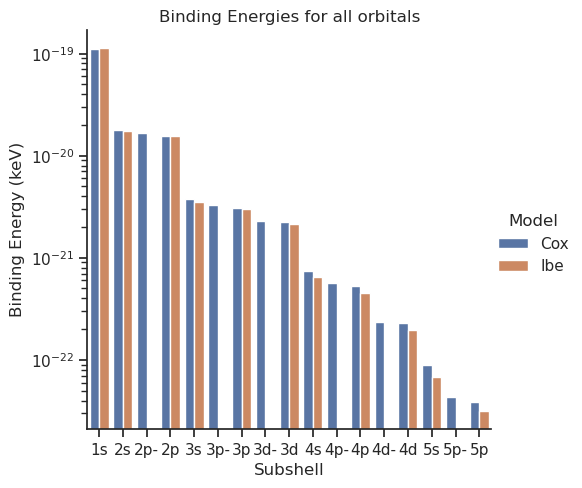

In [17]:
g = sns.catplot(data=all_shells, y="Binding_E", x="name", hue="Model", kind="bar")
g.set(ylabel="Binding Energy (keV)", xlabel="Subshell", yscale="log", title="Binding Energies for all orbitals")

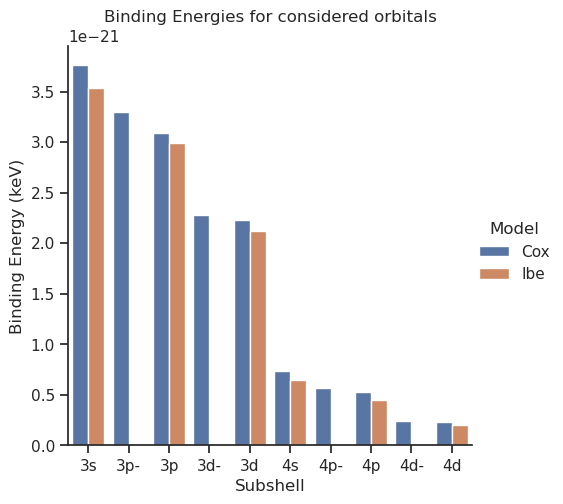

In [18]:
g = sns.catplot(data=considered_shells, y="Binding_E", x="name", hue="Model", kind="bar", order=considered_shells.index.levels[1].values)
g.set(ylabel="Binding Energy (keV)", xlabel="Subshell", title="Binding Energies for considered orbitals")

A check was made by fixing the binding energies for the Ibe model to the ones utilised by Peter Cox *et al*. The resulting rates were the following:

![Image](rates_fixed_binding_energies.png)